In [1]:
# Standard libraries
import os
import pandas as pd
import numpy as np
from PIL import Image
from collections import defaultdict

# Deep learning libraries
import torch

# Visualization
import matplotlib.pyplot as plt

# Source directories
image_folder = "./data/imgs"
label_file = "./data/car_imgs_4000.csv"

In [2]:
# Print the number of files in the folder
fileList = os.listdir(image_folder)
print(f"Number of files in the image folder: {len(fileList)}")

# Check file types present in the folder
file_types = set()

for file in fileList:
    _, ext = os.path.splitext(file)
    if ext: 
        file_types.add(ext.lower())

print("File types found in the folder:")
for file_type in file_types:
    print(file_type)

# Check wether the dimensions of each image is the same and create a numpy array from images
resolutions = []
X = []

for filename in os.listdir(image_folder):
    if filename.lower().endswith('.jpg'):
        image_path = os.path.join(image_folder, filename)
        with Image.open(image_path) as img:
            resolution = img.size 
            resolutions.append((filename, resolution))

first_resolution = resolutions[0][1] if resolutions else None
all_same = all(resolution == first_resolution for _, resolution in resolutions)

if all_same:
    print(f"All images have the same resolution: {first_resolution}")
else:
    print("Different solutions.")
    for filename, resolution in resolutions:
        print(f"{filename}: {resolution}")

Number of files in the image folder: 4000
File types found in the folder:
.jpg
All images have the same resolution: (674, 506)


In [3]:
# Check for duplicate images in the dataset

unique_images, unique_indeces = np.unique(X, axis=0, return_counts=True)

if len(unique_images) < len(X):
    print("Exact duplicates found in the dataset.")
else:
    print("No exact duplicates found in the dataset.")

No exact duplicates found in the dataset.


In [4]:
# Check if an image exists for every file name in the csv 

# Load label file
label_df = pd.read_csv(label_file)

print(label_df.head())

images = []
labels = []

# List for label file names that don't correspond to an image in the folder
missing_images = []

for idx, row in label_df.iterrows():
    filename = row['filename']
    image_path = os.path.join(image_folder, filename)
    
    if os.path.isfile(image_path):
        try:
            with Image.open(image_path) as img:
                img = img.convert('RGB') 
                img_array = np.array(img)
                images.append(img_array)
                
                label = [row['perspective_score_hood'], row['perspective_score_backdoor_left']]
                labels.append(label)
        except Exception as e:
            print(f"Error loading image {filename}: {e}")
            missing_images.append(filename)
    else:
        print(f"Image file {filename} does not exist in the image folder.")
        missing_images.append(filename)

# Create numpy arrays for data and labels
X = np.array(images)
Y = np.array(labels)

if missing_images:
    print(f"\nTotal missing or unreadable images: {len(missing_images)}")
    print("List of missing/unreadable images:")
    for img in missing_images:
        print(img)
else:
    print("\nAll images from the CSV file have a corresponding image in the image folder.")

                                   filename  perspective_score_hood  \
0  66ee2d88-f403-4821-a370-8a3d72e200f9.jpg                 0.27352   
1  bf7e237e-f12b-4ffc-8d79-6855cc35ea06.jpg                 0.00000   
2  4c297488-c81f-464d-92bf-1c408333a912.jpg                 0.00000   
3  6c95ad0b-fda6-42a8-a33d-b430073e1dcd.jpg                 0.00000   
4  bd806d94-4c2e-4cd2-8e02-5eaba7c7c63e.jpg                 0.00000   

   perspective_score_backdoor_left  
0                         0.439526  
1                         0.902682  
2                         0.900864  
3                         0.213162  
4                         0.818388  

All images from the CSV file have a corresponding image in the image folder.


In [5]:
# Save numpy arrays for later use in the dataloader

save_directory = '../data/numpy'
X_file_path = os.path.join(save_directory, 'images.npy')
Y_file_path = os.path.join(save_directory, 'labels.npy')

if not os.path.exists(save_directory):
    os.makedirs(save_directory)

np.save(X_file_path, X)
np.save(Y_file_path, Y)

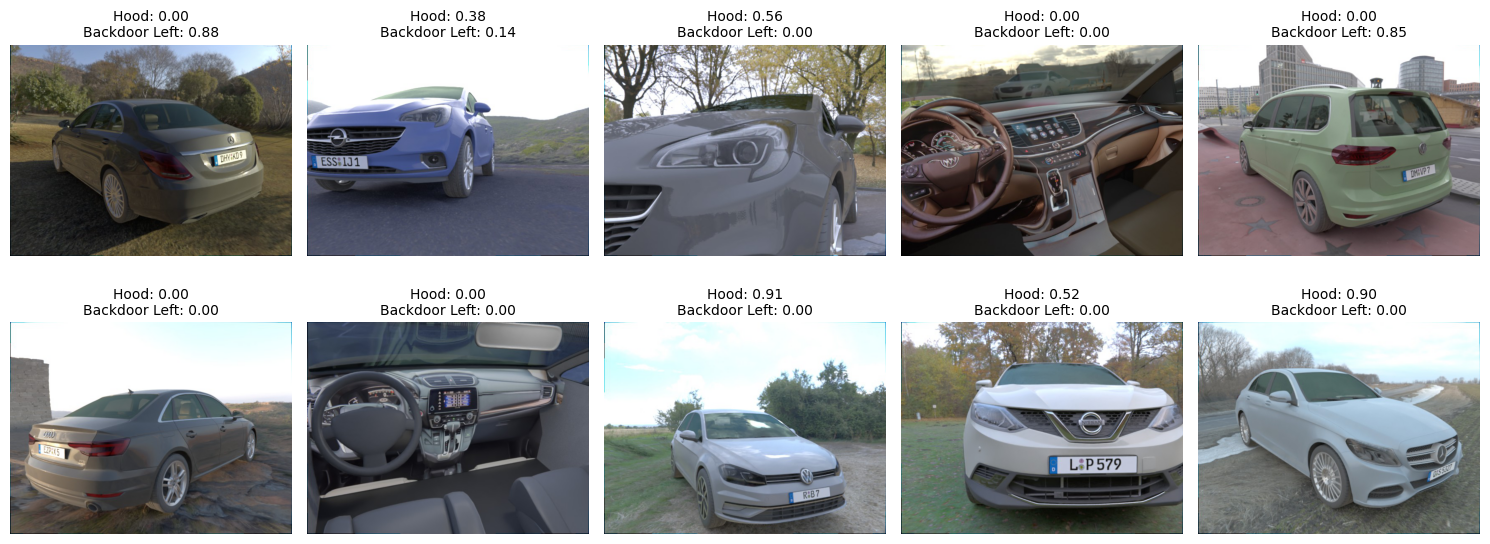

In [60]:
# Display ten random images and their labels from the original dataset

def plot_random_images_with_labels(X, Y, num_images=10):
    random_indices = np.random.choice(X.shape[0], num_images, replace=False)

    plt.figure(figsize=(15, 6))
    
    for i, idx in enumerate(random_indices):
        plt.subplot(2, 5, i + 1)
        plt.imshow(X[idx])
        plt.axis('off') 

        label_str = f"Hood: {Y[idx, 0]:.2f}\nBackdoor Left: {Y[idx, 1]:.2f}"
        plt.title(label_str, fontsize=10)


    plt.tight_layout()
    plt.show()

plot_random_images_with_labels(X, Y, num_images=10)

In [52]:
# Explore label statistics
print(f"Perspective Hood Mean: {Y[:,0].mean()} \n"
      f"Perspective Hood Standard Deviation: {Y[:,0].std()} \n"
      f"Perspective Hood Minimum and Maximum: {Y[:,0].min()}, {Y[:,0].max()} \n"
      f"Perspective Hood Median: {np.median(Y[:,0])}")

print(f"Perspective Backdoor Left Mean: {Y[:,1].mean()} \n"
      f"Perspective Backdoor Left Standard Deviation: {Y[:,1].std()} \n"
      f"Perspective Backdoor Left Minimum and Maximum: {Y[:,1].min()}, {Y[:,1].max()} \n"
      f"Perspective Backdoor Left Median: {np.median(Y[:,1])}")

print("Correlation:", np.corrcoef(Y[:, 0], Y[:, 1]))

Perspective Hood Mean: 0.30303198100175 
Perspective Hood Standard Deviation: 0.382534520084068 
Perspective Hood Minimum and Maximum: 0.0, 0.92242765 
Perspective Hood Median: 0.0
Perspective Backdoor Left Mean: 0.31336786319750004 
Perspective Backdoor Left Standard Deviation: 0.37228734397847446 
Perspective Backdoor Left Minimum and Maximum: 0.0, 0.9395413 
Perspective Backdoor Left Median: 0.0
Correlation: [[ 1.         -0.21201307]
 [-0.21201307  1.        ]]


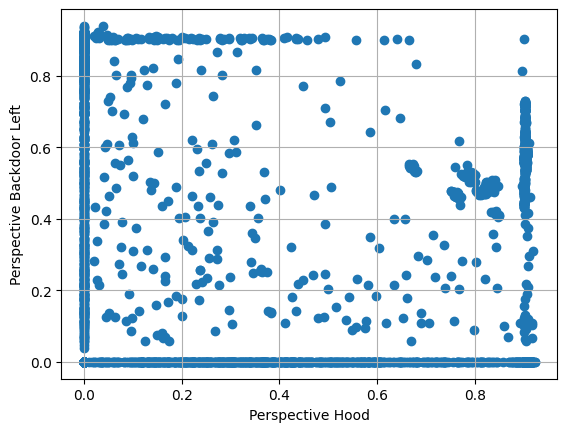

In [53]:
# Scatterplot of the labels

plt.scatter(Y[:, 0], Y[:, 1])
plt.xlabel("Perspective Hood")
plt.ylabel("Perspective Backdoor Left")
plt.grid(True)

plt.show()

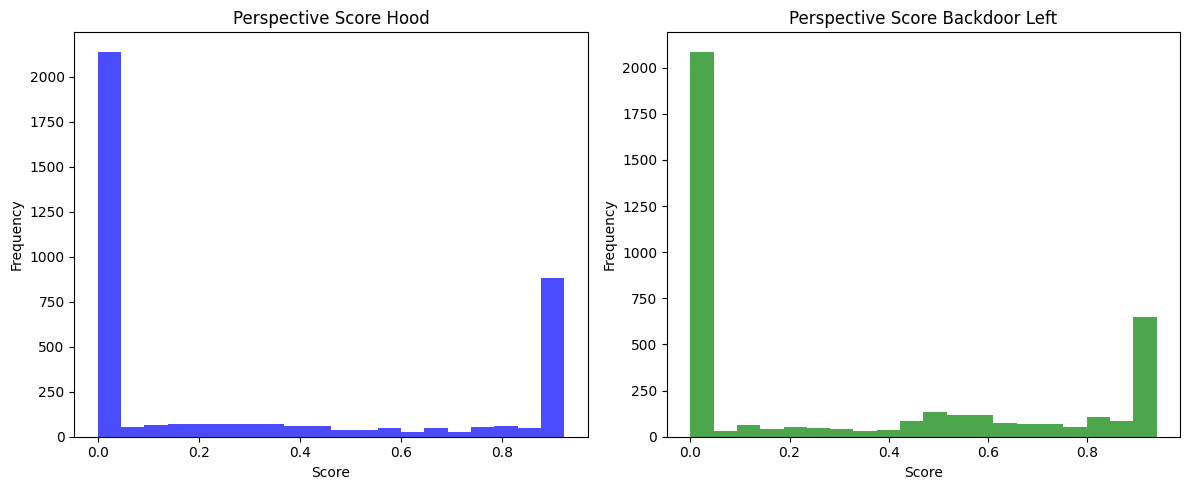

In [10]:
# Create Histograms for both scores individually
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# perspective_score_hood
axs[0].hist(Y[:, 0], bins=20, color='blue', alpha=0.7)
axs[0].set_title('Perspective Score Hood')
axs[0].set_xlabel('Score')
axs[0].set_ylabel('Frequency')

# perspective_score_backdoor_left
axs[1].hist(Y[:, 1], bins=20, color='green', alpha=0.7)
axs[1].set_title('Perspective Score Backdoor Left')
axs[1].set_xlabel('Score')
axs[1].set_ylabel('Frequency')


plt.tight_layout()
plt.show()

In [54]:
# Discretize labels by applying binning with threshold > 0.5, check label distribution

Y_tensor = torch.tensor(Y)
X_tensor = torch.tensor(X)

# Perspective hood: convert to binary class labels (assuming threshold 0.5 for class 0)
binary_labels = (Y_tensor[:, 0] > 0.5).long()

# Count instances of each class
unique, counts = binary_labels.unique(return_counts=True)
class_counts = dict(zip(unique.tolist(), counts.tolist()))
print("Class distribution perspective hood:", class_counts)

# Same for perspective backdoor left
binary_labels = (Y_tensor[:, 1] > 0.5).long()

unique, counts = binary_labels.unique(return_counts=True)
class_counts = dict(zip(unique.tolist(), counts.tolist()))
print("Class distribution backdoor left:", class_counts)

Class distribution perspective hood: {0: 2759, 1: 1241}
Class distribution backdoor left: {0: 2612, 1: 1388}


In [56]:
# Check counts of 4 groups with threshold > 0.5: 
# 1. No hood, no backdoor 2. Only hood, 3. Only backdoor 4. Hood and backdoor

binary_labels = (Y_tensor > 0.5).long()

composite_labels = binary_labels[:, 0] * 2 + binary_labels[:, 1]

class_counts = torch.bincount(composite_labels)
print("Class distribution:", class_counts)

Class distribution: tensor([1692, 1067,  920,  321])


In [59]:
# Create separate and undersampled datasets for each perspective score (even class distribution). Example perspective hood:

binary_labels = (Y_tensor[:, 0] > 0.5).long()

# Find class indices
class_indices = defaultdict(list)
for i, label in enumerate(binary_labels):
    class_indices[label.item()].append(i)

# Determine minimum class count
min_class_count = min(len(indices) for indices in class_indices.values())

# Randomly sample from each class
undersampled_indices = []
for indices in class_indices:
    sampled_indices = np.random.choice(class_indices[indices], min_class_count, replace=False)
    undersampled_indices.extend(sampled_indices)

# Convert to tensor
undersampled_indices = torch.tensor(undersampled_indices, dtype=torch.long)

# Index data and labels
undersampled_data = X_tensor[undersampled_indices]
undersampled_labels = binary_labels[undersampled_indices]

# Save as numpy
undersampled_data = undersampled_data.numpy()
undersampled_labels = undersampled_labels.numpy()

folder_path = '../data/numpy_undersampled'

# Create the folder if it does not exist
os.makedirs(folder_path, exist_ok=True)

# Define file paths
X_file_path = os.path.join(folder_path, 'X_data.npy')
Y_file_path = os.path.join(folder_path, 'Y_labels.npy')

# Save NumPy arrays to .npy files
np.save(X_file_path, undersampled_data)
np.save(Y_file_path, undersampled_labels)

print(f"Data saved to {folder_path}")

Data saved to ../data/numpy_undersampled
